<a href="https://colab.research.google.com/github/KozinIS/CV/blob/main/05_%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D1%8F_%D0%B8%D0%B7%D0%BE%D0%B1%D1%80%D0%B0%D0%B6%D0%B5%D0%BD%D0%B8%D0%B9_(VAE%2C_CVAE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Генерация изображений (VAE, CVAE)**

# 1 Постановка задачи

1. Подготовьте вариационный автокодировщик (VAE) и вариационный автокодировщик с условием (CVAE), предназначенные для генерации графических изображений цифр.
2. Попробуйте разные размеры скрытого пространства VAE - 10, 20, 100, 200. Опишите результаты сравнения.
3. Подготовьте свёрточный VAE. Опишите разницу результатов с полносвязным.
4. Подготовьте более мощный CVAE. Обучите больше эпох до более низкого уровня ошибки и сравните изображения, которые получаются в итоге. Укажите в выводах, коррелирует ли уровень ошибки с качеством изображений.
5. Подайте 5 раз в decoder CVAE один и тот же случайный вектор и label любой от 0 до 9 на выбор. Обратите внимание на то, что сгенерирует CVAE.


# 2 Вариационный автокодировщик (VAE)

## 2.1 Подгрузка баз

In [ ]:
!pip install keras==2.0 -q # загружаем эту версию кераса для корректной работы скрипта
!pip install tensorflow==1.0 -q  # загружаем эту версию тензорфлоу  для корректной работы скрипта

     |████████████████████████████████| 194kB 8.7MB/s 
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.0 which is incompatible.
     |████████████████████████████████| 44.5MB 67kB/s 


In [ ]:
import sys # модуль содержит параметры и функции, которые относятся к Python и его среде
import numpy as np # загружаем библиотеку для работы с массивами данных
import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
import seaborn as sns # более высокоуровневое API на базе библиотеки matplotlib
from scipy.stats import norm # модуль с нормальными непрерывными случайными величинами

from keras.datasets import mnist # загружаем готовую стандартную базу рукописных цифр mnist
from keras.optimizers import Adam, RMSprop # загружаем выбранные оптимизаторы
from keras.layers import Input, Dense  # загружаем необходимые слои(входной, полносвязный)
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda, Conv1D, Conv2D # загружаем слои(нормализации, регуляризации и т.д)
from keras.models import Model # загружаем абстрактный класс базовой модели сети от кераса

from keras.objectives import binary_crossentropy # импортируем функцию потерь
from keras.layers.advanced_activations import LeakyReLU # импортируем функцию активации отдельным слоем
from keras import backend as K # устанавливаем переменную для окружения кераса
from IPython.display import clear_output # импортируем модуль очистки output'а ячейки
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard # импортируем коллбэки

## 2.2 Формирование обучающей выборки

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # загружаем данные из базы mnist с разбивкой на train/test

x_train = x_train.astype('float32') / 255. # представляем x_train в виде значений от 0 до 1
x_test  = x_test .astype('float32') / 255. # представляем x_test в виде значений от 0 до 1
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # меняем форму, приводим к нужным нам размерам
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) # меняем форму, приводим к нужным нам размерам

## 2.3 Создание и обучение автокодировщика № 1
*(размер скрытого пространства - 10)*

In [ ]:
batch_size = 500 # размер батча
latent_dim = 10 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения

In [ ]:
def create_vae(): # объявляем функцию создания вариационного автокодировщика
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(batch_shape=(batch_size, 28, 28, 1)) # размерности батч, строк, столбцов, фильтров одной картинки
    x = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    x = Dense(256, activation='relu')(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(128, activation='relu')(x) # полносвязный слой на 128 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации

    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 10

    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 10

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их

        # Керасовским методом делаем нормальное распределение(500 10тимерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)

        return z_mean + K.exp(z_log_var / 2) * epsilon

    # Задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (10,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l, 'Encoder') # модель энкодера от входа до лямбда слоя

    models["z_meaner"] = Model(input_img, z_mean, 'Enc_z_mean') # отдельная модель с путем от входа до z_mean

    models["z_lvarer"] = Model(input_img, z_log_var, 'Enc_z_log_var') # отдельная модель с путем от входа до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем входную размерность (10,)
    x = Dense(128)(z) # полносвязный слой на 128 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(256)(x) # полносвязный слой на 256 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model(z, decoded, name='Decoder') # собираем модель декодера

    # Cобираем вариационный автокодировщик, также двойное преобразование над входной картинкой(энкодер-декодер)
    models["vae"] = Model(input_img, models["decoder"](models["encoder"](input_img)), name='VAE')

    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models["vae"] # задаем модель вариационного автокодировщика

In [ ]:
vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

In [ ]:
digit_size = 28 # задаем размеры цифр

def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args]  # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран

n = 15 # Картинка с 15x15 цифр
digit_size = 28


In [ ]:
# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = vae.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

        # Сохранение многообразия и распределения z для создания анимации после
        epochs.append(epoch)
        #figs.append(figure)
        latent_distrs.append(encoder_mean.predict(x_test, batch_size))

# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
encoder_mean.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (500, 28, 28, 1)          0         
_________________________________________________________________
flatten_1 (Flatten)          (500, 784)                0         
_________________________________________________________________
dense_1 (Dense)              (500, 256)                200960    
_________________________________________________________________
batch_normalization_1 (Batch (500, 256)                1024      
_________________________________________________________________
dropout_1 (Dropout)          (500, 256)                0         
_________________________________________________________________
dense_2 (Dense)              (500, 128)                32896     
_________________________________________________________________
batch_normalization_2 (Batch (500, 128)                512       
__________

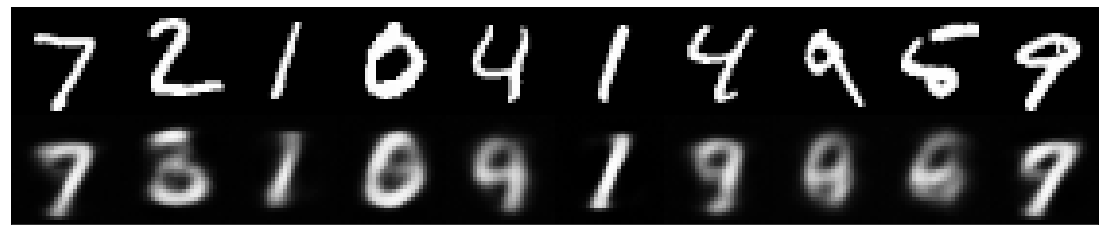

60000/60000 [==============================] - 22s - loss: 0.1110 - val_loss: 0.0983
Epoch 17/20
60000/60000 [==============================] - 21s - loss: 0.1090 - val_loss: 0.0968
Epoch 18/20
60000/60000 [==============================] - 21s - loss: 0.1074 - val_loss: 0.0955
Epoch 19/20
60000/60000 [==============================] - 21s - loss: 0.1059 - val_loss: 0.0943
Epoch 20/20
60000/60000 [==============================] - 21s - loss: 0.1044 - val_loss: 0.0932


In [ ]:
# Запуск обучения
vae.fit(x_train, x_train, shuffle=True, epochs=20,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

## 2.4 Создание и обучение автокодировщика № 2
*(размер скрытого пространства - 20)*

In [ ]:
batch_size = 500 # размер батча
latent_dim = 20 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения

In [ ]:
def create_vae(): # объявляем функцию создания вариационного автокодировщика
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(batch_shape=(batch_size, 28, 28, 1)) # размерности батч, строк, столбцов, фильтров одной картинки
    x = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    x = Dense(256, activation='relu')(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(128, activation='relu')(x) # полносвязный слой на 128 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации

    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 10

    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 10

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их

        # Керасовским методом делаем нормальное распределение(500 10тимерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)

        return z_mean + K.exp(z_log_var / 2) * epsilon

    # Задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (10,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l, 'Encoder') # модель энкодера от входа до лямбда слоя

    models["z_meaner"] = Model(input_img, z_mean, 'Enc_z_mean') # отдельная модель с путем от входа до z_mean

    models["z_lvarer"] = Model(input_img, z_log_var, 'Enc_z_log_var') # отдельная модель с путем от входа до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем входную размерность (10,)
    x = Dense(128)(z) # полносвязный слой на 128 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(256)(x) # полносвязный слой на 256 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model(z, decoded, name='Decoder') # собираем модель декодера

    # Cобираем вариационный автокодировщик, также двойное преобразование над входной картинкой(энкодер-декодер)
    models["vae"] = Model(input_img, models["decoder"](models["encoder"](input_img)), name='VAE')

    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models["vae"] # задаем модель вариационного автокодировщика

In [ ]:
vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

In [ ]:
digit_size = 28 # задаем размеры цифр

def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args]  # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран

n = 15 # Картинка с 15x15 цифр
digit_size = 28


In [ ]:
# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = vae.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

        # Сохранение многообразия и распределения z для создания анимации после
        epochs.append(epoch)
        #figs.append(figure)
        latent_distrs.append(encoder_mean.predict(x_test, batch_size))

# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
encoder_mean.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (500, 28, 28, 1)          0         
_________________________________________________________________
flatten_2 (Flatten)          (500, 784)                0         
_________________________________________________________________
dense_8 (Dense)              (500, 256)                200960    
_________________________________________________________________
batch_normalization_5 (Batch (500, 256)                1024      
_________________________________________________________________
dropout_5 (Dropout)          (500, 256)                0         
_________________________________________________________________
dense_9 (Dense)              (500, 128)                32896     
_________________________________________________________________
batch_normalization_6 (Batch (500, 128)                512       
__________

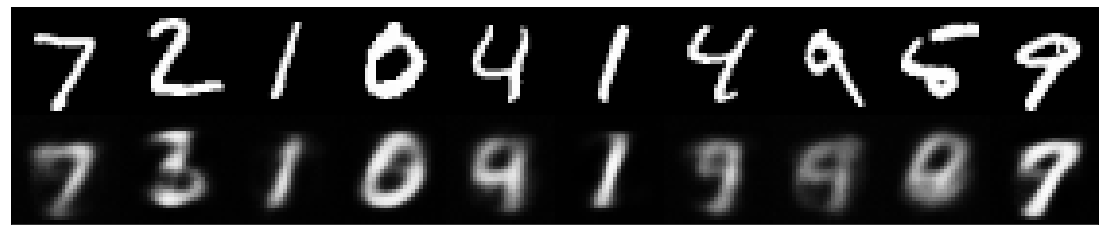

60000/60000 [==============================] - 21s - loss: 0.1139 - val_loss: 0.1004
Epoch 17/20
60000/60000 [==============================] - 21s - loss: 0.1120 - val_loss: 0.0992
Epoch 18/20
60000/60000 [==============================] - 20s - loss: 0.1105 - val_loss: 0.0980
Epoch 19/20
60000/60000 [==============================] - 21s - loss: 0.1091 - val_loss: 0.0969
Epoch 20/20
60000/60000 [==============================] - 20s - loss: 0.1077 - val_loss: 0.0960


In [ ]:
# Запуск обучения
vae.fit(x_train, x_train, shuffle=True, epochs=20,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

## 2.5 Создание и обучение автокодировщика № 3
*(размер скрытого пространства - 100)*

In [ ]:
batch_size = 500 # размер батча
latent_dim = 100 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения

In [ ]:
def create_vae(): # объявляем функцию создания вариационного автокодировщика
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(batch_shape=(batch_size, 28, 28, 1)) # размерности батч, строк, столбцов, фильтров одной картинки
    x = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    x = Dense(256, activation='relu')(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(128, activation='relu')(x) # полносвязный слой на 128 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации

    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 10

    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 10

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их

        # Керасовским методом делаем нормальное распределение(500 10тимерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)

        return z_mean + K.exp(z_log_var / 2) * epsilon

    # Задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (10,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l, 'Encoder') # модель энкодера от входа до лямбда слоя

    models["z_meaner"] = Model(input_img, z_mean, 'Enc_z_mean') # отдельная модель с путем от входа до z_mean

    models["z_lvarer"] = Model(input_img, z_log_var, 'Enc_z_log_var') # отдельная модель с путем от входа до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем входную размерность (10,)
    x = Dense(128)(z) # полносвязный слой на 128 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(256)(x) # полносвязный слой на 256 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model(z, decoded, name='Decoder') # собираем модель декодера

    # Cобираем вариационный автокодировщик, также двойное преобразование над входной картинкой(энкодер-декодер)
    models["vae"] = Model(input_img, models["decoder"](models["encoder"](input_img)), name='VAE')

    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models["vae"] # задаем модель вариационного автокодировщика

In [ ]:
vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

In [ ]:
digit_size = 28 # задаем размеры цифр

def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args]  # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран

n = 15 # Картинка с 15x15 цифр
digit_size = 28


In [ ]:
# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = vae.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

        # Сохранение многообразия и распределения z для создания анимации после
        epochs.append(epoch)
        #figs.append(figure)
        latent_distrs.append(encoder_mean.predict(x_test, batch_size))

# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
encoder_mean.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (500, 28, 28, 1)          0         
_________________________________________________________________
flatten_3 (Flatten)          (500, 784)                0         
_________________________________________________________________
dense_15 (Dense)             (500, 256)                200960    
_________________________________________________________________
batch_normalization_9 (Batch (500, 256)                1024      
_________________________________________________________________
dropout_9 (Dropout)          (500, 256)                0         
_________________________________________________________________
dense_16 (Dense)             (500, 128)                32896     
_________________________________________________________________
batch_normalization_10 (Batc (500, 128)                512       
__________

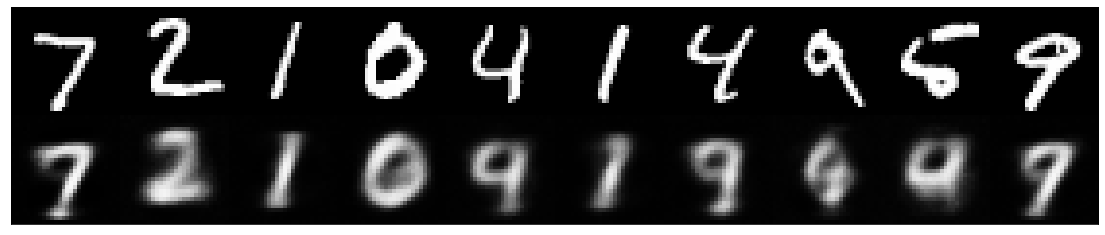

60000/60000 [==============================] - 23s - loss: 0.1213 - val_loss: 0.1048
Epoch 17/20
60000/60000 [==============================] - 22s - loss: 0.1193 - val_loss: 0.1040
Epoch 18/20
60000/60000 [==============================] - 22s - loss: 0.1177 - val_loss: 0.1030
Epoch 19/20
60000/60000 [==============================] - 22s - loss: 0.1163 - val_loss: 0.1023
Epoch 20/20
60000/60000 [==============================] - 22s - loss: 0.1150 - val_loss: 0.1015


In [ ]:
# Запуск обучения
vae.fit(x_train, x_train, shuffle=True, epochs=20,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

## 2.6 Создание и обучение автокодировщика № 4
*(размер скрытого пространства - 200)*

In [ ]:
batch_size = 500 # размер батча
latent_dim = 200 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения

In [ ]:
def create_vae(): # объявляем функцию создания вариационного автокодировщика
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(batch_shape=(batch_size, 28, 28, 1)) # размерности батч, строк, столбцов, фильтров одной картинки
    x = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    x = Dense(256, activation='relu')(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(128, activation='relu')(x) # полносвязный слой на 128 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации

    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 10

    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 10

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их

        # Керасовским методом делаем нормальное распределение(500 10тимерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)

        return z_mean + K.exp(z_log_var / 2) * epsilon

    # Задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (10,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l, 'Encoder') # модель энкодера от входа до лямбда слоя

    models["z_meaner"] = Model(input_img, z_mean, 'Enc_z_mean') # отдельная модель с путем от входа до z_mean

    models["z_lvarer"] = Model(input_img, z_log_var, 'Enc_z_log_var') # отдельная модель с путем от входа до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем входную размерность (10,)
    x = Dense(128)(z) # полносвязный слой на 128 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(256)(x) # полносвязный слой на 256 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model(z, decoded, name='Decoder') # собираем модель декодера

    # Cобираем вариационный автокодировщик, также двойное преобразование над входной картинкой(энкодер-декодер)
    models["vae"] = Model(input_img, models["decoder"](models["encoder"](input_img)), name='VAE')

    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models["vae"] # задаем модель вариационного автокодировщика

In [ ]:
vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

In [ ]:
digit_size = 28 # задаем размеры цифр

def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args]  # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран

n = 15 # Картинка с 15x15 цифр
digit_size = 28


In [ ]:
# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = vae.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

        # Сохранение многообразия и распределения z для создания анимации после
        epochs.append(epoch)
        #figs.append(figure)
        latent_distrs.append(encoder_mean.predict(x_test, batch_size))

# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
encoder_mean.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (500, 28, 28, 1)          0         
_________________________________________________________________
flatten_4 (Flatten)          (500, 784)                0         
_________________________________________________________________
dense_22 (Dense)             (500, 256)                200960    
_________________________________________________________________
batch_normalization_13 (Batc (500, 256)                1024      
_________________________________________________________________
dropout_13 (Dropout)         (500, 256)                0         
_________________________________________________________________
dense_23 (Dense)             (500, 128)                32896     
_________________________________________________________________
batch_normalization_14 (Batc (500, 128)                512       
__________

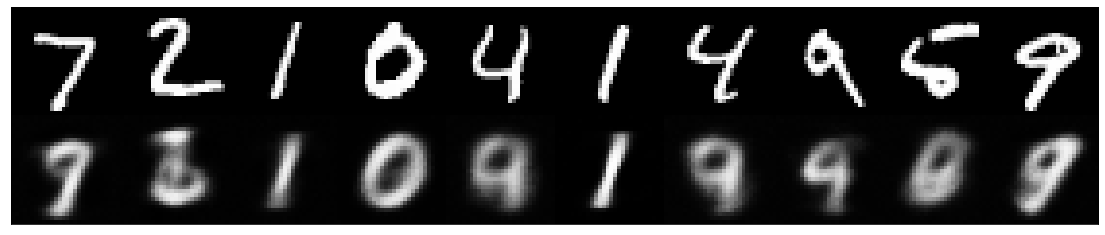

60000/60000 [==============================] - 24s - loss: 0.1221 - val_loss: 0.1059
Epoch 17/20
60000/60000 [==============================] - 23s - loss: 0.1202 - val_loss: 0.1050
Epoch 18/20
60000/60000 [==============================] - 23s - loss: 0.1185 - val_loss: 0.1042
Epoch 19/20
60000/60000 [==============================] - 23s - loss: 0.1171 - val_loss: 0.1036
Epoch 20/20
60000/60000 [==============================] - 23s - loss: 0.1158 - val_loss: 0.1030


In [ ]:
# Запуск обучения
vae.fit(x_train, x_train, shuffle=True, epochs=20,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

## 2.7 Создание и обучение автокодировщика № 5
*(свёрточный VAE)*

In [ ]:
batch_size = 500 # размер батча
latent_dim = 20 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.0001 # шаг обучения

In [ ]:
def create_vae(): # объявляем функцию создания вариационного автокодировщика
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(batch_shape=(batch_size, 28, 28, 1)) # размерности батч, строк, столбцов, фильтров одной картинки
    x = Conv2D(8, (2,2), padding='same', activation='relu')(input_img)
    x = BatchNormalization() (x)
    x = Conv2D(8, (2,2), padding='same', activation='relu')(x)
    x = BatchNormalization() (x)
    x = Flatten()(x) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    x = Dense(256, activation='relu')(x) # полносвязный слой на 256 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(128, activation='relu')(x) # полносвязный слой на 128 нейронов
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации

    # Предсказываем параметры распределений
    # Вместо того, чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации

    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 10

    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 10

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их

        # Керасовским методом делаем нормальное распределение(500 10тимерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)

        return z_mean + K.exp(z_log_var / 2) * epsilon

    # Задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (10,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model(input_img, l, 'Encoder') # модель энкодера от входа до лямбда слоя

    models["z_meaner"] = Model(input_img, z_mean, 'Enc_z_mean') # отдельная модель с путем от входа до z_mean

    models["z_lvarer"] = Model(input_img, z_log_var, 'Enc_z_log_var') # отдельная модель с путем от входа до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем входную размерность (10,)
    x = Dense(128)(z) # полносвязный слой на 128 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(256)(x) # полносвязный слой на 256 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model(z, decoded, name='Decoder') # собираем модель декодера

    # Cобираем вариационный автокодировщик, также двойное преобразование над входной картинкой(энкодер-декодер)
    models["vae"] = Model(input_img, models["decoder"](models["encoder"](input_img)), name='VAE')

    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_vae() # получаем модели и свою функцию потерь
vae = models["vae"] # задаем модель вариационного автокодировщика

In [ ]:
vae.compile(optimizer=Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь

In [ ]:
digit_size = 28 # задаем размеры цифр

def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args]  # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран

n = 15 # Картинка с 15x15 цифр
digit_size = 28


In [ ]:
# Массивы, в которые будем сохранять результаты, для последующей визуализации
latent_distrs = []
epochs = []

# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]

# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = vae.predict(imgs, batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])

        # Сохранение многообразия и распределения z для создания анимации после
        epochs.append(epoch)
        #figs.append(figure)
        latent_distrs.append(encoder_mean.predict(x_test, batch_size))

# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
encoder_mean.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (500, 28, 28, 1)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (500, 28, 28, 8)          40        
_________________________________________________________________
batch_normalization_7 (Batch (500, 28, 28, 8)          32        
_________________________________________________________________
conv2d_4 (Conv2D)            (500, 28, 28, 8)          264       
_________________________________________________________________
batch_normalization_8 (Batch (500, 28, 28, 8)          32        
_________________________________________________________________
flatten_2 (Flatten)          (500, 6272)               0         
_________________________________________________________________
dense_8 (Dense)              (500, 256)                1605888   
__________

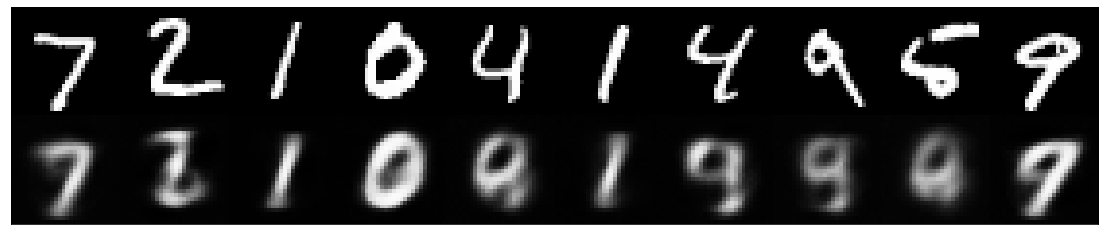

60000/60000 [==============================] - 275s - loss: 0.1132 - val_loss: 0.0997
Epoch 17/20
60000/60000 [==============================] - 264s - loss: 0.1114 - val_loss: 0.0983
Epoch 18/20
60000/60000 [==============================] - 264s - loss: 0.1097 - val_loss: 0.0972
Epoch 19/20
60000/60000 [==============================] - 264s - loss: 0.1083 - val_loss: 0.0960
Epoch 20/20
60000/60000 [==============================] - 265s - loss: 0.1070 - val_loss: 0.0951


In [ ]:
# Запуск обучения
vae.fit(x_train, x_train, shuffle=True, epochs=20,
        batch_size=batch_size,
        validation_data=(x_test, x_test),
        callbacks=[pltfig],
        verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

## 2.8 Результаты обучения

Результаты работы созданных нейронных сетей представлены в таблице.

In [ ]:
import pandas as pd

In [ ]:
results = {'Наименование': ['Нейросеть № 1', 'Нейросеть № 2', 'Нейросеть № 3', 'Нейросеть № 4', 'Нейросеть № 5'],
        'Размер скрытого пространства': ['10', '20', '100', '200', '20'],
        'Значение ошибки на проверочной выборке (после 20 эпох)': [0.0932, 0.0960, 0.1015, 0.1030, 0.0951],
        'Время обучения (сек., на 1 эпоху)': [21, 20, 22, 23, 265],
        'Процент достаточно точно сгенерированных случайных картинок': ['40', '50', '50', '50', '70']}

results_base = pd.DataFrame(results)

In [ ]:
results_base.head(10)

,Наименование,Размер скрытого пространства,Значение ошибки на проверочной выборке (после 20 эпох),"Время обучения (сек., на 1 эпоху)",Процент достаточно точно сгенерированных случайных картинок
0,Нейросеть № 1,10,0.0932,21,40
1,Нейросеть № 2,20,0.0960,20,50
2,Нейросеть № 3,100,0.1015,22,50
3,Нейросеть № 4,200,0.1030,23,50
4,Нейросеть № 5,20,0.0951,265,70


## 2.9 Выводы

Разработаны и обучены на 20-ти эпохах пять нейронных сетей, предназначенных для генерации графических изображений цифр. К основным выводам можно отнести следующее:
1. Наилучшие результаты показала нейронная сеть, включающая в свой состав два свёрточных слоя Conv2D (порядка 70 % картинок сгенерированы с достаточно высокой степнью чёткости). В то же время такая сеть потребовала значительно больше времени на обучение (больше 4-х минут на одну эпоху).
2. Чем меньше размер скрытого пространства, тем меньше значение ошибки на проверочной выборке и тем быстрее осуществляется обучение.
3. Нельзя сделать однозначный вывод о том, что уменьшение значения ошибки приводит к улучшению качества сгенерированных изображений.

# 3 Вариационный автокодиорвщик с условием (CVAE)

## 3.1 Подгрузка баз

In [ ]:
!pip install keras==2.0 -q # загружаем эту версию кераса для корректной работы скрипта
!pip install tensorflow==1.0 -q  # загружаем эту версию тензорфлоу  для корректной работы скрипта

In [ ]:
import sys # модуль содержит параметры и функции, которые относятся к Python и его среде
import numpy as np # загружаем библиотеку для работы с массивами данных
import matplotlib.pyplot as plt # из библиотеки для визуализации данных возьмём интерфейс для построения графиков простых функций
%matplotlib inline
from scipy.stats import norm # модуль с нормальными непрерывными случайными величинами

from keras.datasets import mnist # загружаем готовую стандартную базу рукописных цифр mnist
from keras.utils import to_categorical # загружаем утилиты кераса для one-hot кодировки
from keras.layers import Input, Dense # загружаем необходимые слои(входной, полносвязный)
from keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Lambda # загружаем слои(нормализации, регуляризации и т.д)
from keras.layers import concatenate # подгружаем слой конкатенации
from keras.models import Model # загружаем абстрактный класс базовой модели сети от кераса
from keras.objectives import binary_crossentropy # импортируем функцию потерь
from keras.layers.advanced_activations import LeakyReLU # импортируем функцию активации
from keras import backend as K # устанавливаем переменную для окружения кераса
from keras.optimizers import Adam, RMSprop # загружаем выбранные оптимизаторы
from IPython.display import clear_output # импортируем модуль очистки output'а ячейки
from keras.callbacks import LambdaCallback, ReduceLROnPlateau, TensorBoard # импортируем коллбэки

## 3.2 Формирование обучающей выборки

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() # загружаем данные из базы mnist с разбивкой на train/test

x_train = x_train.astype('float32') / 255. # представляем x_train в виде значений от 0 до 1
x_test  = x_test .astype('float32') / 255. # представляем x_test в виде значений от 0 до 1
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1)) # меняем форму, приводим к нужным нам размерам
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1)) # меняем форму, приводим к нужным нам размерам

y_train_cat = to_categorical(y_train).astype(np.float32) # переводим обучающие лейблы в one-hot кодировку
y_test_cat  = to_categorical(y_test).astype(np.float32) # переводим проверочные лейблы в one-hot кодировку
num_classes = y_test_cat.shape[1] # задаем количество классов

## 3.3 Созание и обучение автокодировщика № 1 (как на лекции)

In [ ]:
batch_size = 500 # размер батча
latent_dim = 8 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.001 # шаг обучения

In [ ]:

def create_cvae(): # объявляем функцию создания вариационного автокодировщика c условием
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(shape=(28, 28, 1)) # размерности строк, столбцов, фильтров одной картинки
    flatten_img = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    input_lbl = Input(shape=(num_classes,), dtype='float32') # второй вход в энкодер с учетом лейблов и по количеству классов

    x = concatenate([flatten_img, input_lbl]) # конкатенируем входы сглаженной входной картинки и input_lbl

    x = Dense(256, activation='relu')(x) # полносвязный слой на 256 нейронов

    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации

    # Предсказываем параметры распределений

    # Вместо того чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 8
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 8

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        # керасовским методом делаем нормальное распределение(500 8мерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (8,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model([input_img, input_lbl], l, 'Encoder') # модель энкодера от входов до лямбда слоя
    models["z_meaner"] = Model([input_img, input_lbl], z_mean, 'Enc_z_mean') # отдельная модель с путем от входов до z_mean
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var, 'Enc_z_log_var') # отдельная модель с путем от входов до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем первую входную размерность (8,)
    input_lbl_d = Input(shape=(num_classes,), dtype='float32') # задаем вторую входную размерность по номеру классов
    x = concatenate([z, input_lbl_d]) # конкатенируем входы
    x = Dense(256)(x) # полносвязный слой на 256 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model([z, input_lbl_d], decoded, name='Decoder') # собираем модель декодера

    # Cобираем вариационный автокодировщик с условием(3 инпута на входе, затем первые два проходят через энкодер,
    # складываются с input_lbl_d и всё это проходит через декодер на выходе)
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d],
                              models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]),
                              name="CVAE")
    # Та же операция, но вместо энкодера модель z_meaner
    models["style_t"] = Model( [input_img, input_lbl, input_lbl_d] ,
                               models["decoder"] ( [models["z_meaner"]([input_img, input_lbl]), input_lbl_d] ) ,
                               name="style_transfer")


    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_cvae() # получаем модели и свою функцию потерь
cvae = models["cvae"] # задаем модель вариационного автокодировщика с условием

In [ ]:
cvae.compile(optimizer = Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь
cvae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_7 (InputLayer)             (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
input_8 (InputLayer)             (None, 10)            0                                            
____________________________________________________________________________________________________
Encoder (Model)                  (None, 8)             208656                                       
____________________________________________________________________________________________________
input_10 (InputLayer)            (None, 10)            0                                            
___________________________________________________________________________________________

In [ ]:
digit_size = 28 # задаем размеры цифр
def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args] # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран


n = 15 # Картинка с 15x15 цифр

In [ ]:
# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]


# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])



# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
# lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
tb     = TensorBoard(log_dir='./logs')

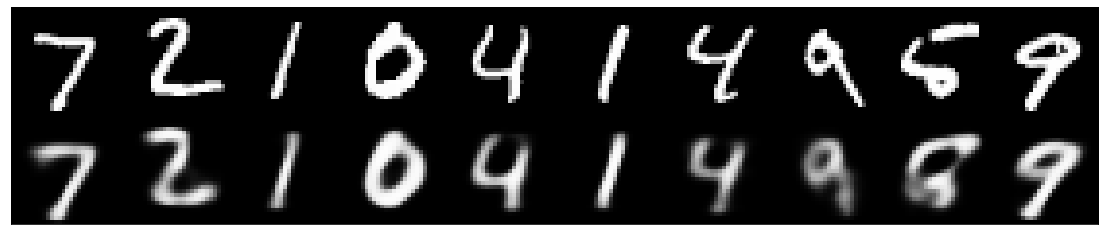

60000/60000 [==============================] - 19s - loss: 0.0823 - val_loss: 0.0760
Epoch 17/20
60000/60000 [==============================] - 19s - loss: 0.0822 - val_loss: 0.0759
Epoch 18/20
60000/60000 [==============================] - 19s - loss: 0.0820 - val_loss: 0.0756
Epoch 19/20
60000/60000 [==============================] - 19s - loss: 0.0819 - val_loss: 0.0755
Epoch 20/20
60000/60000 [==============================] - 19s - loss: 0.0819 - val_loss: 0.0754


In [ ]:
# Запуск обучения
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=20,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig, tb],
         verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

## 3.4 Созание и обучение автокодировщика № 2 (более мощного)

In [ ]:
batch_size = 500 # размер батча
latent_dim = 8 # размер скрытого слоя/пространства
dropout_rate = 0.3 # размер слоя регуляризации, "выключим" указанное количество нейронов, во избежание переобучения
start_lr = 0.001 # шаг обучения

In [ ]:
def create_cvae(): # объявляем функцию создания вариационного автокодировщика c условием
    models = {} # задаем словарь моделей

    # Добавим Dropout и BatchNormalization
    def apply_bn_and_dropout(x): # функция будет принимать на вход слой x
        return Dropout(dropout_rate)(BatchNormalization()(x)) # и применять к нему регуляризацию/нормализацию

    # Энкодер
    input_img = Input(shape=(28, 28, 1)) # размерности строк, столбцов, фильтров одной картинки
    flatten_img = Flatten()(input_img) # добавляем слой выравнивания/сглаживания ("сплющиваем" данные в вектор)
    input_lbl = Input(shape=(num_classes,), dtype='float32') # второй вход в энкодер с учетом лейблов и по количеству классов

    x = concatenate([flatten_img, input_lbl]) # конкатенируем входы сглаженной входной картинки и input_lbl

    x = Dense(256, activation='relu')(x) # полносвязный слой на 256 нейронов
    x = Dropout(0.3) (x)
    x = Dense(128, activation='relu')(x) # полносвязный слой на 256 нейронов

    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации

    # Предсказываем параметры распределений

    # Вместо того чтобы предсказывать стандартное отклонение, предсказываем логарифм вариации
    z_mean = Dense(latent_dim)(x) # скрытое пространство(мат.ожидание) размером 8
    z_log_var = Dense(latent_dim)(x) # скрытое пространство(лог.вариации) размером 8

    # Сэмплирование из Q с трюком репараметризации
    def sampling(args): # обьявляем функцию сэмплирования
        z_mean, z_log_var = args # принимаем в аргументах z_mean, z_log_var, раскусываем их
        # керасовским методом делаем нормальное распределение(500 8мерных), мат.ожидание 0, ст.отклонение 1
        epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
        return z_mean + K.exp(z_log_var / 2) * epsilon

    # задаем самописный слой, к-й принимает лист [z_mean, z_log_var], семплирует, и на выходе выдает размерность (8,)
    l = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    models["encoder"]  = Model([input_img, input_lbl], l, 'Encoder') # модель энкодера от входов до лямбда слоя
    models["z_meaner"] = Model([input_img, input_lbl], z_mean, 'Enc_z_mean') # отдельная модель с путем от входов до z_mean
    models["z_lvarer"] = Model([input_img, input_lbl], z_log_var, 'Enc_z_log_var') # отдельная модель с путем от входов до z_log_var

    # Декодер
    z = Input(shape=(latent_dim, )) # задаем первую входную размерность (8,)
    input_lbl_d = Input(shape=(num_classes,), dtype='float32') # задаем вторую входную размерность по номеру классов
    x = concatenate([z, input_lbl_d]) # конкатенируем входы
    x = Dense(256)(x) # полносвязный слой на 256 нейронов
    x = Dropout(0.3) (x)
    x = Dense(128)(x) # полносвязный слой на 256 нейронов
    x = LeakyReLU()(x) # применяем функцию активации отдельным слоем
    x = apply_bn_and_dropout(x) # применяем функцию добавления регуляризации/нормализации
    x = Dense(28*28, activation='sigmoid')(x) # полносвязный слой на 784 нейрона
    decoded = Reshape((28, 28, 1))(x) # меняем форму, приводим к нужным нам размерам

    models["decoder"] = Model([z, input_lbl_d], decoded, name='Decoder') # собираем модель декодера

    # Cобираем вариационный автокодировщик с условием(3 инпута на входе, затем первые два проходят через энкодер,
    # складываются с input_lbl_d и всё это проходит через декодер на выходе)
    models["cvae"]    = Model([input_img, input_lbl, input_lbl_d],
                              models["decoder"]([models["encoder"]([input_img, input_lbl]), input_lbl_d]),
                              name="CVAE")
    # Та же операция, но вместо энкодера модель z_meaner
    models["style_t"] = Model( [input_img, input_lbl, input_lbl_d] ,
                               models["decoder"] ( [models["z_meaner"]([input_img, input_lbl]), input_lbl_d] ) ,
                               name="style_transfer")


    def vae_loss(x, decoded): # объявляем самописную функцию потерь
        x = K.reshape(x, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) x через керасовскую функцию
        decoded = K.reshape(decoded, shape=(batch_size, 28*28)) # меняем размеры(в одномерный) decoded через керасовскую функцию
        xent_loss = 28*28*binary_crossentropy(x, decoded) # берем бинарную кроссэнтропию между x и decoded, с учетом пикселей
        kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # по формуле устанавливаем ошибку kl_loss
        return (xent_loss + kl_loss)/2/28/28 # функция вернет суммарную ошибку с учетом распределения и размеров пикселей

    return models, vae_loss

models, vae_loss = create_cvae() # получаем модели и свою функцию потерь
cvae = models["cvae"] # задаем модель вариационного автокодировщика с условием

In [ ]:
cvae.compile(optimizer = Adam(start_lr), loss=vae_loss) # компилируем модель с выбранным оптимайзером и своей функцией потерь
cvae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_23 (InputLayer)            (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
input_24 (InputLayer)            (None, 10)            0                                            
____________________________________________________________________________________________________
Encoder (Model)                  (None, 8)             238992                                       
____________________________________________________________________________________________________
input_26 (InputLayer)            (None, 10)            0                                            
___________________________________________________________________________________________

In [ ]:
digit_size = 28 # задаем размеры цифр
def plot_digits(*args, invert_colors=False): # функция отрисует две линии картинок - оригинальные и выходные из автокодировщика
    args = [x.squeeze() for x in args] # удаляем оси с одним элементом из аргументов
    n = min([x.shape[0] for x in args]) # берем минимальное от нулевой оси x'ов в аргументах
    figure = np.zeros((digit_size * len(args), digit_size * n)) # создаем фигуру с использованием массива нулей по заданным размерам

    for i in range(n):
        for j in range(len(args)): # заполняем фигуру значениями
            figure[j * digit_size: (j + 1) * digit_size,
                   i * digit_size: (i + 1) * digit_size] = args[j][i].squeeze()

    if invert_colors: # если значение invert_colors будет True
        figure = 1-figure # то фигуру делаем обратной

    plt.figure(figsize=(2*n, 2*len(args))) # плотим фигуру с заданными значениями
    plt.imshow(figure, cmap='Greys_r') # выведем ее на экран в указанных цветах
    plt.grid(False) # указываем, что сетка не нужна
    ax = plt.gca() # получаем текущий объект Axes
    ax.get_xaxis().set_visible(False) # ось координат xaxis делаем невидимой
    ax.get_yaxis().set_visible(False) # ось координат yaxis делаем невидимой
    plt.show() # выводим отрисованное на экран


n = 15 # Картинка с 15x15 цифр

In [ ]:
# Эпохи, в которые будем сохранять
save_epochs = set([i*5 for i in range(0,25)])

# Отслеживать будем на вот этих цифрах
imgs = x_test[:batch_size]
imgs_lbls = y_test_cat[:batch_size]
n_compare = 10

# Модели
generator      = models["decoder"]
encoder_mean   = models["z_meaner"]


# Функция, которую будем запускать после каждой эпохи
def on_epoch_end(epoch, logs):
    if epoch in save_epochs:
        clear_output() # Не захламляем output

        # Сравнение реальных и декодированных цифр
        decoded = cvae.predict([imgs, imgs_lbls, imgs_lbls], batch_size=batch_size)
        plot_digits(imgs[:n_compare], decoded[:n_compare])



# Коллбэки
pltfig = LambdaCallback(on_epoch_end=on_epoch_end)
# lr_red = ReduceLROnPlateau(factor=0.1, patience=25)
tb     = TensorBoard(log_dir='./logs')

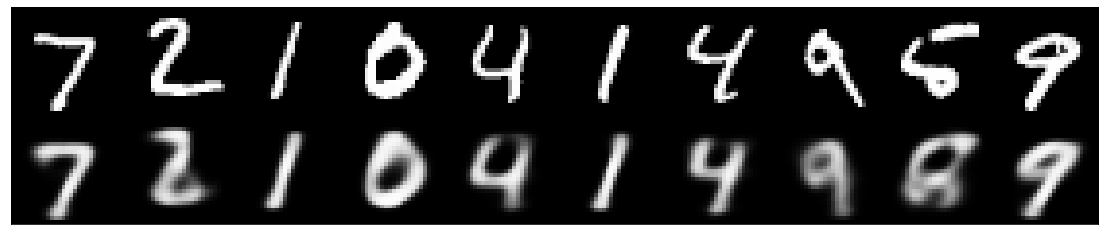

60000/60000 [==============================] - 18s - loss: 0.0883 - val_loss: 0.0795
Epoch 22/25
60000/60000 [==============================] - 18s - loss: 0.0881 - val_loss: 0.0796
Epoch 23/25
60000/60000 [==============================] - 18s - loss: 0.0881 - val_loss: 0.0795
Epoch 24/25
60000/60000 [==============================] - 18s - loss: 0.0880 - val_loss: 0.0793
Epoch 25/25
60000/60000 [==============================] - 18s - loss: 0.0879 - val_loss: 0.0793


In [ ]:
# Запуск обучения
cvae.fit([x_train, y_train_cat, y_train_cat], x_train, shuffle=True, epochs=25,
         batch_size=batch_size,
         validation_data=([x_test, y_test_cat, y_test_cat], x_test),
         callbacks=[pltfig, tb],
         verbose=1) # грузим наши данные в модель, задаем параметры и обучаем

## 3.5 Результаты обучения

In [ ]:
def style_transfer(model, X, lbl_in, lbl_out): # объявляем функцию переноса стилей
    rows = X.shape[0]
    if isinstance(lbl_in, int): # заполняем входные лейблы(энкодера)
        lbl = lbl_in
        lbl_in = np.zeros((rows, 10)) # построчное заполнение нулями от 0 до 9
        lbl_in[:, lbl] = 1 # заполняем в нужную строчку единицу
    if isinstance(lbl_out, int): # заполняем выходные лейблы(декодера)
        lbl = lbl_out
        lbl_out = np.zeros((rows, 10)) # построчное заполнение нулями от 0 до 9
        lbl_out[:, lbl] = 1 # заполняем в нужную строчку единицу
    #print(lbl_in)
    #print(lbl_out)
    return model.predict([X, lbl_in, lbl_out]) # функция вернет предсказанные картинки

Проверка № 1 (label = 1)

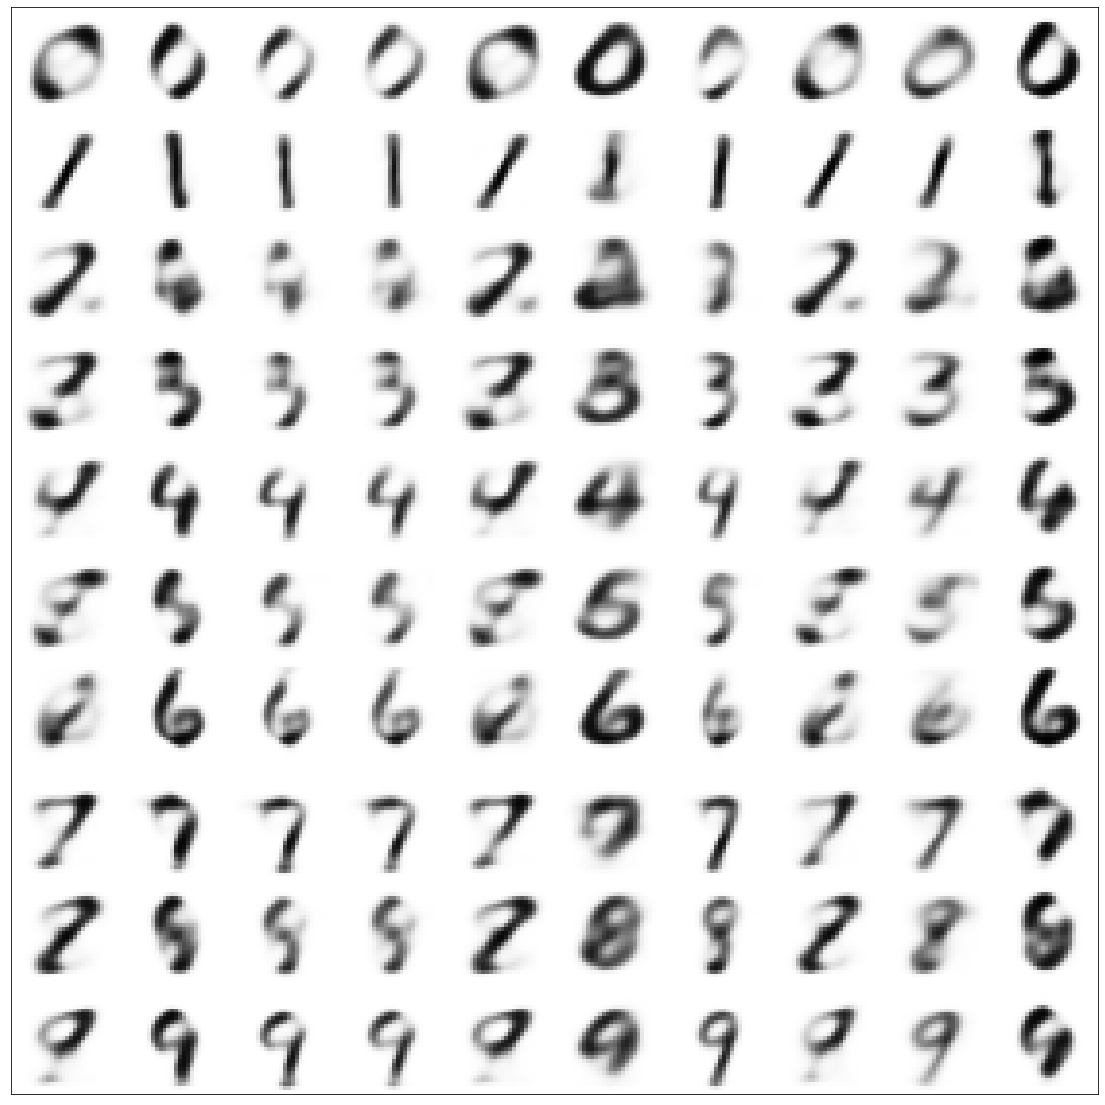

In [ ]:
n = 10 # выбираем количество картинок
lbl = 1 # выбираем лейбл
generated = [] # здесь соберем список сгенерированных картинок
prot = x_train[y_train == lbl][:n] # возьмем prot в качестве x с соответствующим выбранному значению лейбла

for i in range(num_classes): # идем по каждому классу
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) # и генерим картинки с учетом переноса стиля

#generated[lbl] = prot
plot_digits(*generated, invert_colors=True) # отрисовываем картинки

Проверка № 2 (label = 3)

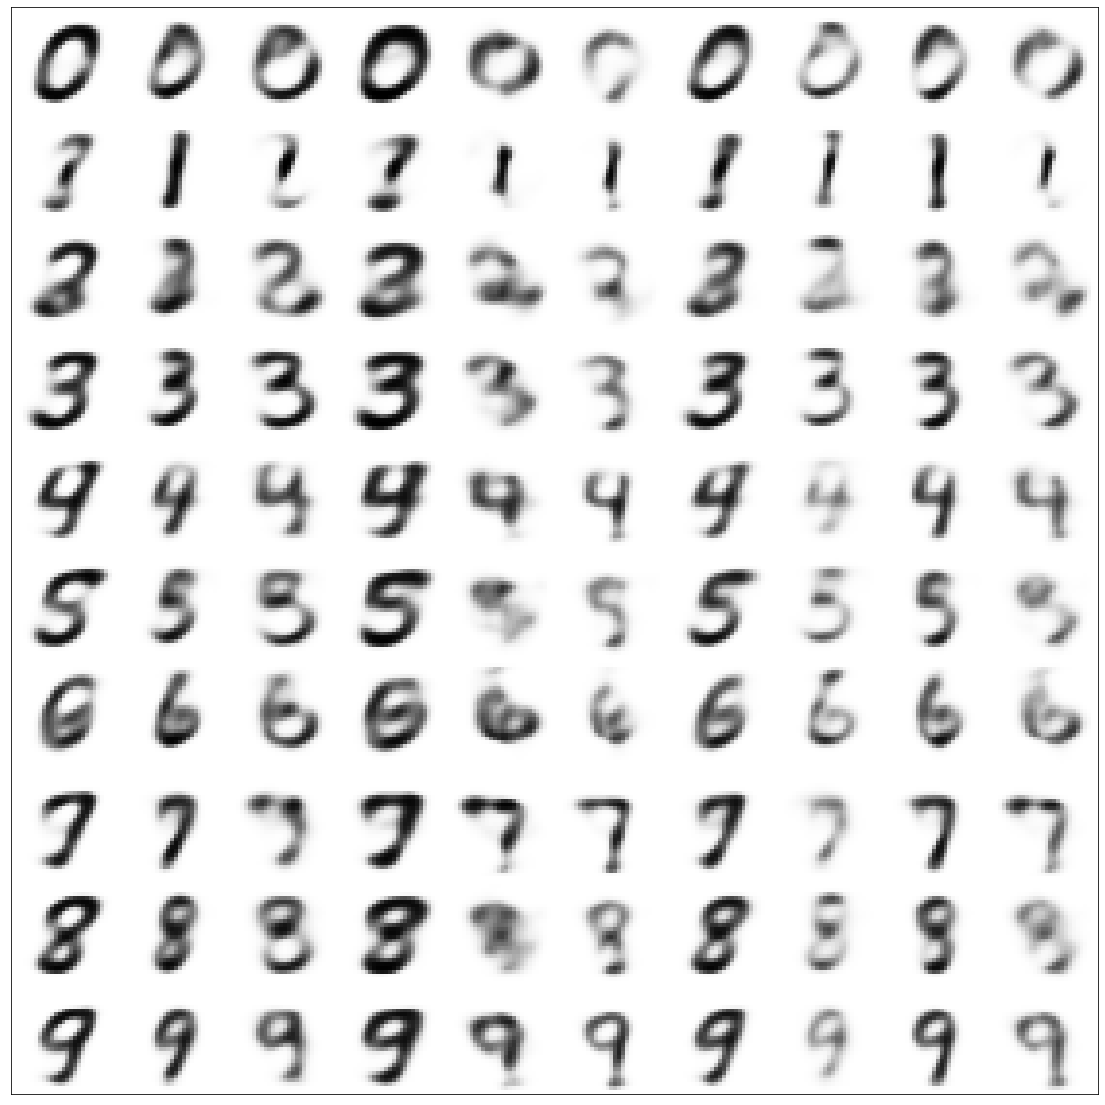

In [ ]:
n = 10 # выбираем количество картинок
lbl = 3 # выбираем лейбл
generated = [] # здесь соберем список сгенерированных картинок
prot = x_train[y_train == lbl][:n] # возьмем prot в качестве x с соответствующим выбранному значению лейбла

for i in range(num_classes): # идем по каждому классу
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) # и генерим картинки с учетом переноса стиля

#generated[lbl] = prot
plot_digits(*generated, invert_colors=True) # отрисовываем картинки

Проверка № 3 (label = 4)

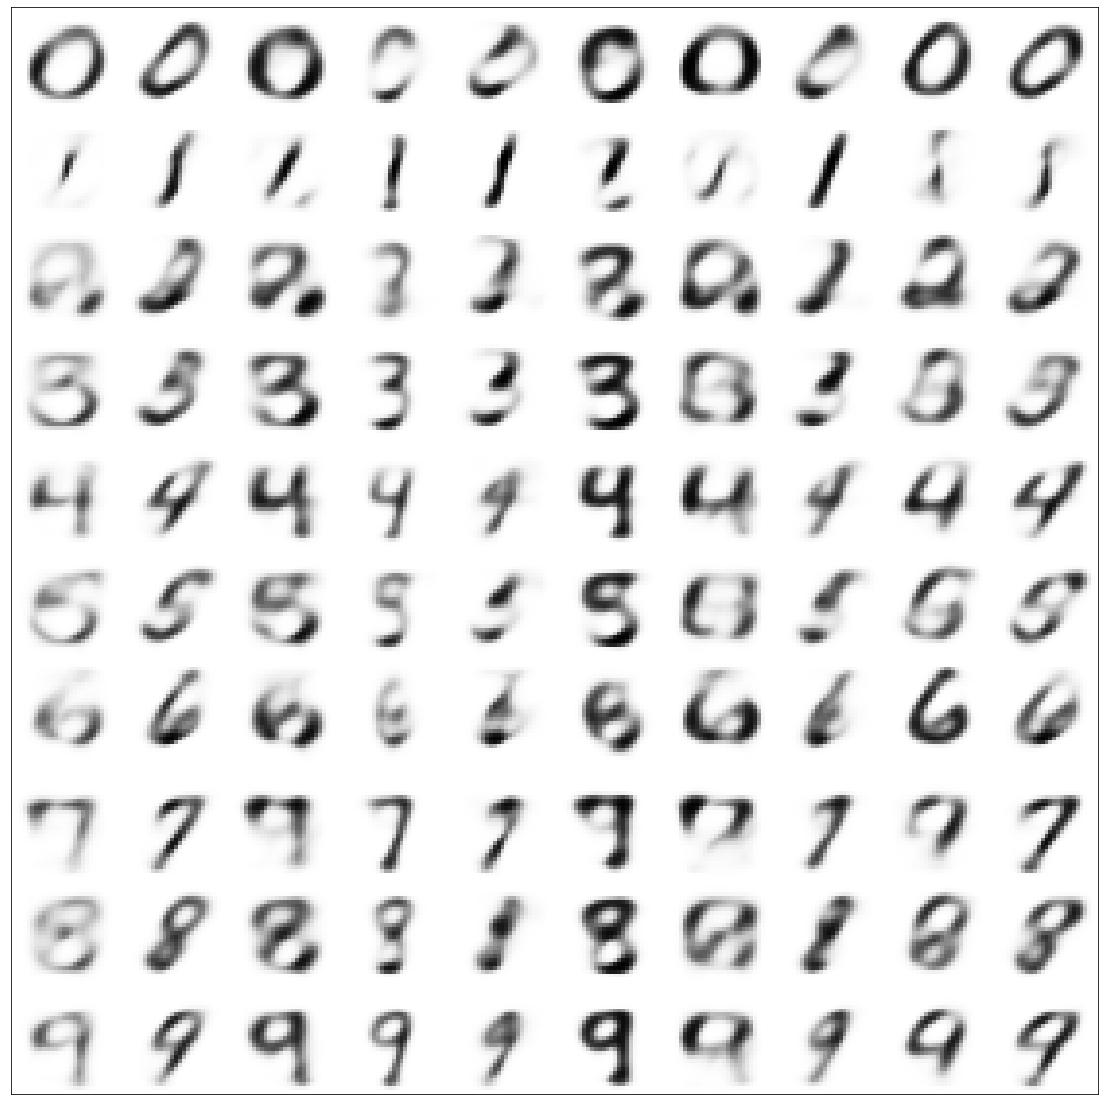

In [ ]:
n = 10 # выбираем количество картинок
lbl = 4 # выбираем лейбл
generated = [] # здесь соберем список сгенерированных картинок
prot = x_train[y_train == lbl][:n] # возьмем prot в качестве x с соответствующим выбранному значению лейбла

for i in range(num_classes): # идем по каждому классу
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) # и генерим картинки с учетом переноса стиля

#generated[lbl] = prot
plot_digits(*generated, invert_colors=True) # отрисовываем картинки

Проверка № 4 (label = 5)

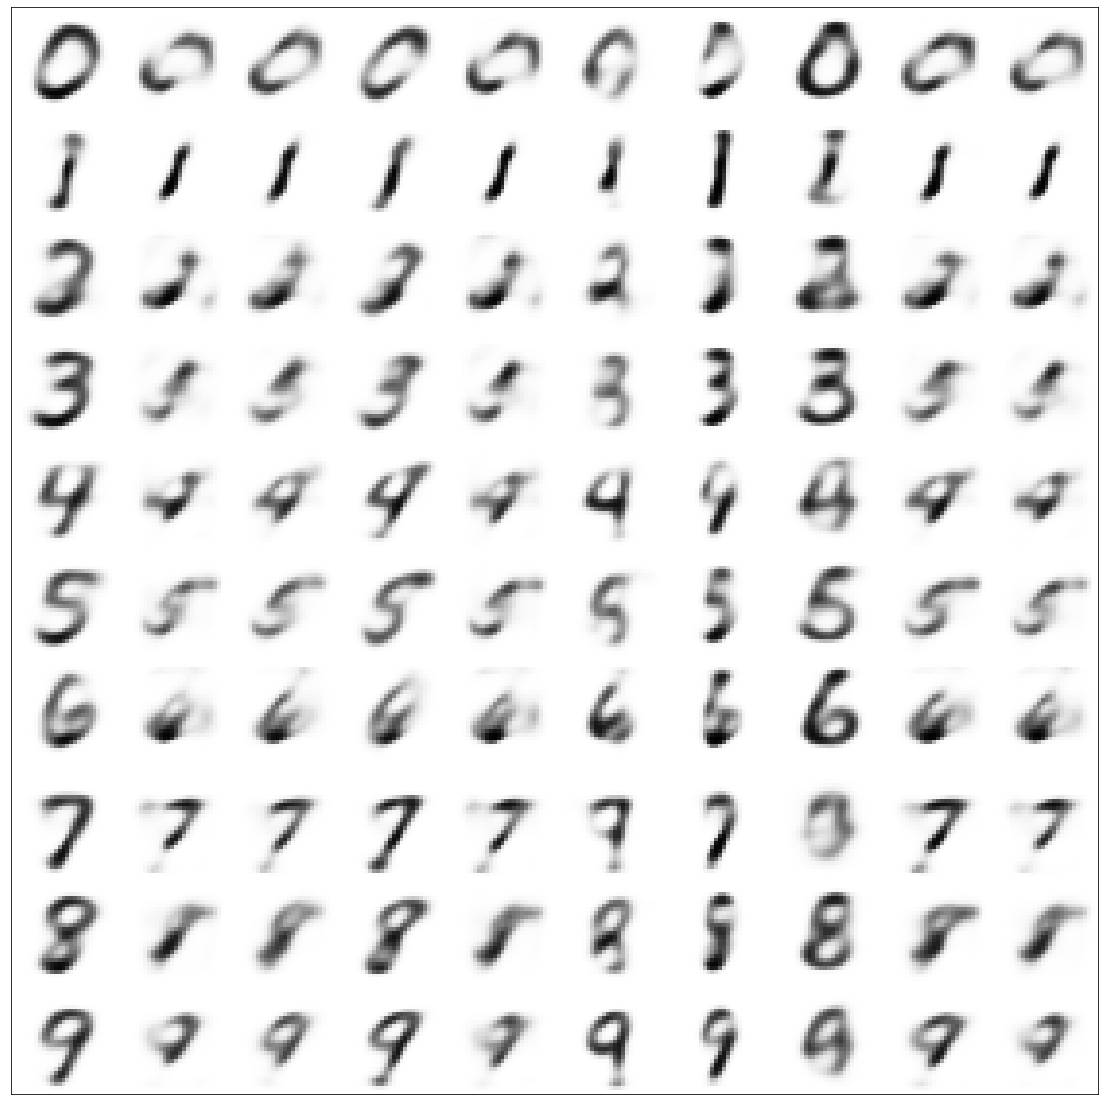

In [ ]:
n = 10 # выбираем количество картинок
lbl = 5 # выбираем лейбл
generated = [] # здесь соберем список сгенерированных картинок
prot = x_train[y_train == lbl][:n] # возьмем prot в качестве x с соответствующим выбранному значению лейбла

for i in range(num_classes): # идем по каждому классу
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) # и генерим картинки с учетом переноса стиля

#generated[lbl] = prot
plot_digits(*generated, invert_colors=True) # отрисовываем картинки

Проверка № 5 (label = 7)

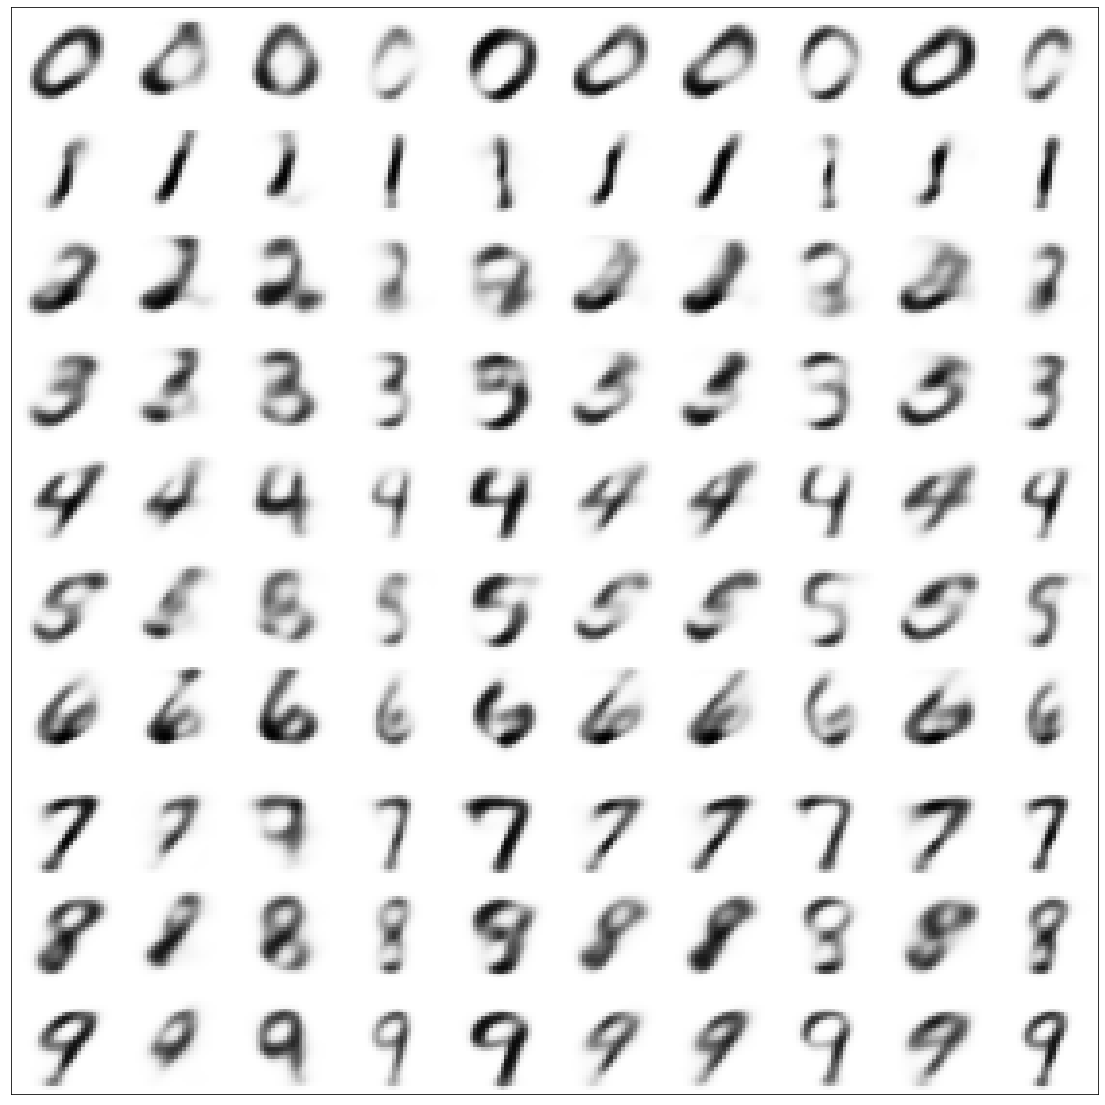

In [ ]:
n = 10 # выбираем количество картинок
lbl = 7 # выбираем лейбл
generated = [] # здесь соберем список сгенерированных картинок
prot = x_train[y_train == lbl][:n] # возьмем prot в качестве x с соответствующим выбранному значению лейбла

for i in range(num_classes): # идем по каждому классу
    generated.append(style_transfer(models["style_t"], prot, lbl, i)) # и генерим картинки с учетом переноса стиля

#generated[lbl] = prot
plot_digits(*generated, invert_colors=True) # отрисовываем картинки

## 3.6 Выводы

Разработаны и обучены два вариационных автокодировщика - эталонный (как на лекции) и более мощный.

Более мощный отличается от эталонного включением в его состав двух скрытых слоёв Dense(128) (по дному в энкодер и в декодер, с использованием Dropout(0,3)) и обучением на большем количестве эпох (25).

Значение ошибки более мощного автокодировщика на проверочной выборке составило примерно 0,0793, что ниже значения ошибки эталонного автокодировщика примерно на 0,01.

Результаты работ более мощного автокодировщика проверены пятикратным преобразованием вектора с разными значениями label (1, 3, 4, 5, 7).